In [1]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
%matplotlib notebook

from tqdm import tqdm

# Instacart recommendations

### what this is
1. Quick look at what's in the data
2. Checking for red flags
3. Looking for exploitable trends in the data


### Data Definition

#### orders (415k rows): fact table, one record per order, includes useful time dimensions
- order_id: order identifier
- user_id: customer identifier
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- Order_hour_of_day: hour of day the order was placed
- Days_since_prior_order: Number of days since that customer placed their previous order (NA for order_number = 1)

#### order_products (3.9M rows): fact table, one record per order, per product
_except for last order by a customer_
- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

#### products (50k rows): Dimension table for product info
- product_id: product identifier
- product_name: name of the product
- aisle_id: foreign key
- department_id: foreign key

#### aisles (134 rows): Dimension table for aisle info
- aisle_id: aisle identifier
- aisle: the name of the aisle

#### departments (21 rows): Dimension table for department info
- department_id: department identifier
- department: the name of the department


# 0. Load data

In [2]:
engine = sql.create_engine('sqlite:///instacart.db')
db = {}

In [4]:
for table in ['orders', 'order_products', 'products', 'aisles', 'departments',]:
    db[table] = pd.read_sql_table(table, engine, index_col=0,)

In [5]:
# aliases for easy typing & set index columns
orders = db['orders']
orders.set_index('order_id', inplace=True)

ops = db['order_products']   # default index vs. multi-index on order_id + add_to_cart_order

products = db['products']
del(products['index'])       # index is one off from xxxx_id, confusing
products.set_index('product_id', inplace=True)

del(db['departments']['index'])
db['departments'].set_index('department_id', inplace=True)

del(db['aisles']['index'])
db['aisles'].set_index('aisle_id', inplace=True)

### Build (flat) order details table:

In [6]:
ops.columns, orders.columns, products.columns

(Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object'),
 Index(['user_id', 'order_number', 'order_dow', 'order_hour_of_day',
        'days_since_prior_order'],
       dtype='object'),
 Index(['product_name', 'aisle_id', 'department_id'], dtype='object'))

In [7]:
# merge order_products with product info and order info

order_details = pd.merge(ops, orders, left_on='order_id', right_index=True)
order_details = pd.merge(order_details, products, left_on='product_id', right_index=True)
order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,3,5,9,8.0,Organic Egg Whites,86,16
455,390,33120,28,1,166654,48,0,12,9.0,Organic Egg Whites,86,16
1319,1097,33120,14,1,30502,5,4,0,8.0,Organic Egg Whites,86,16
2201,1887,33120,6,1,25085,78,1,10,3.0,Organic Egg Whites,86,16
3927,3304,33120,4,1,42591,4,1,14,14.0,Organic Egg Whites,86,16


# 1. Customers w/ few orders vs. customers w/ many orders

In [8]:
%matplotlib inline

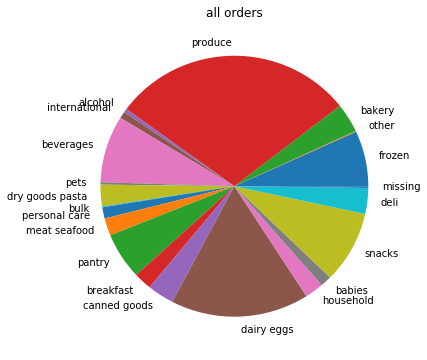

In [129]:
# all orders

fig, ax = plt.subplots()

dept_sales = order_details.groupby('department_id').product_id.size()
ax = dept_sales.plot.pie(y='department_id', legend=False, labels=db['departments'].department)
ax.set_ylabel('')
ax.set_title('all orders')
fig.set_size_inches(6, 6)
plt.show()

In [121]:
# highest order number for each user_id
num_orders = orders.groupby('user_id')['order_number'].max()
num_orders.name = 'total_orders_by_cust'

In [123]:
order_details = pd.merge(order_details, pd.DataFrame(num_orders), left_on='user_id', right_index=True)

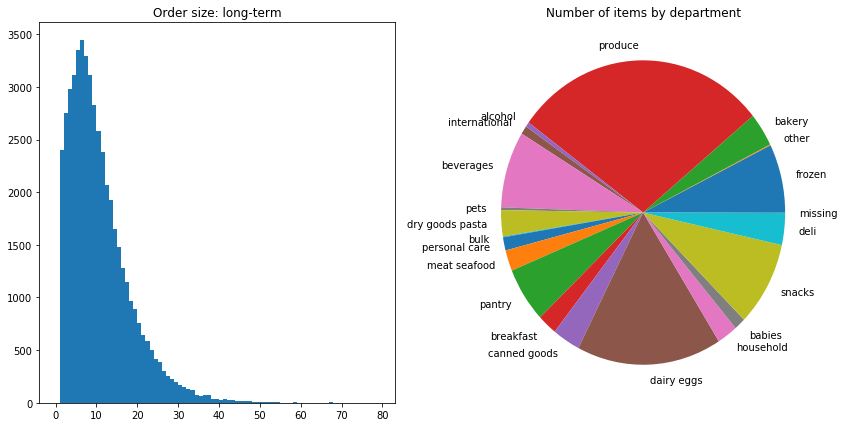

In [210]:
# early orders from long-term customers only ( > 10 orders)

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(14, 7)

ax[0].hist(order_details[(order_details.total_orders_by_cust > 10) & (order_details.order_number < 5)].groupby('order_id').size(), bins=range(80))
ax[0].set_title('Order size: long-term')

ax[1] = (order_details[(order_details.total_orders_by_cust > 10) & (order_details.order_number < 5)]
         .groupby('department_id').size()
         .plot.pie(y='department_id',
                   legend=False,
                   labels=db['departments'].department))
ax[1].set_ylabel('')
ax[1].set_title('Number of items by department')

plt.show()

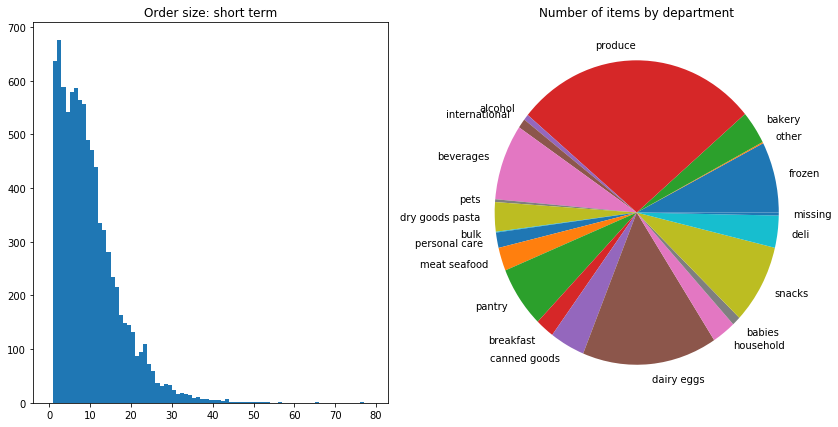

In [223]:
# early orders from short-term customers only (4 orders)

fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(14, 7)

ax[0].hist(order_details[(order_details.total_orders_by_cust < 5) & (order_details.order_number < 5)].groupby('order_id').size(), bins=range(80))
ax[0].set_title('Order size: short term')

ax[1] = (order_details[(order_details.total_orders_by_cust < 5) & (order_details.order_number < 5)]
         .groupby('department_id').size()
         .plot.pie(y='department_id',
                   legend=False,
                   labels=db['departments'].department))
ax[1].set_ylabel('')
ax[1].set_title('Number of items by department')

plt.show()

In [237]:
# there is a correlation between small initial orders and churn; what would the value of this be?

cutoff = 3
short = order_details[(order_details.total_orders_by_cust < 5) & 
                      (order_details.order_number < 5)].groupby('order_id').size()
long = order_details[(order_details.total_orders_by_cust > 10) & 
                     (order_details.order_number < 5)].groupby('order_id').size()

small_orders = 0
for order in short:
    if order < cutoff:
        small_orders += 1
        
print('     % small first orders for short-term customers: {:f}'.format(small_orders/len(short)))
print('number small first orders for short-term customers: {}'.format(small_orders))


small_orders = 0
for order in long:
    if order < cutoff:
        small_orders += 1
        
print('    % small first orders for long-term customers:  {:f}'.format(small_orders/len(long)))
print('number small first orders for long-term customers: {}'.format(small_orders))


     % small first orders for short-term customers: 0.148500
number small first orders for short-term customers: 1312
    % small first orders for long-term customers:  0.104965
number small first orders for long-term customers: 5150


# Conclusion 1:

Customers who have very small initial orders are more likely to stop using Instacart.

However, among users with very small initial orders, many will still continue using the servoce. This group is not specific enough to be purely  to addressing this group. And overall, the distribution of products purchased by short-term users is very similar to that of long-term users.

Potential intervention:
Offer discounts to users with small order sizes to incentivize increasing how much they buy.
e.g. for a user with 4 items in cart: 
### Add one more unique item, get 10% off today's purchase!

In [ ]:
fig, ax = plt.subplots()

aisle_sales = order_details.groupby('aisle_id').size().sort_values()
ax = aisle_sales.plot.pie(y='aisle_id', legend=False)
ax.set_ylabel('')
fig.set_size_inches(6, 6)

for i in range(12):
    which = aisle_sales.index[-1-i]
    print('{} = {}'.format(which, db['aisles'].aisle.loc[which]))

In [ ]:
ax = ops.groupby('order_id').size().plot.hist(bins=102)
ax.set_xlabel('order size (items)')
ax.set_title('Distribution of order sizes')
plt

# distribution of popular products

percent of orders made up by top products

In [ ]:
ax = ops.groupby('product_id').size().plot.hist(bins=100)
ax.set_xlabel('Sales of product')
ax.set_title('Number of orders for product')
plt.show()

In [ ]:
sum(order_details.product_id.value_counts()[:10]) / len(ops) 
# top 10 (of 50k) products: % of order items

In [ ]:
sum(order_details.product_id.value_counts()[:100]) / len(ops) 
# top 100 (of 50k) products: % of order items

In [ ]:
sum(order_details.product_id.value_counts()[:1000]) / len(ops) 
# top 1000 (of 50k) products: % of order items

In [ ]:
sum(order_details.product_id.value_counts()[:10000]) / len(ops) 
# top 20% (of 50k) products: % of order items

# What percent of orders for a product are reorders?

If a product is never reordered or negatively affects customer retrention, this is a problem (that is easy to solve).

In [ ]:
tmp = pd.DataFrame({'reorder_pct': ops.groupby('product_id').reordered.mean(),
                    'num_orders': order_details.groupby('product_id').size()})

In [ ]:
order_details = pd.merge(order_details, tmp, left_on='product_id', right_index=True)

In [ ]:
# plot percentage reorders by department
fig, ax = plt.subplots()
dept_id = 4

print(db['departments'].loc[dept_id])

fig.set_size_inches(9,4)
ax.scatter(order_details.groupby('product_id').size(), 
           order_details.groupby('product_id').reorder_pct.mean(),
           s=2,
           alpha=.2,)

ax.scatter(order_details[order_details.department_id == 4].groupby('product_id').size(), 
           order_details[order_details.department_id == 4].groupby('product_id').reorder_pct.mean(),
           s=1,
           color='red',
           alpha=.3,)

ax.set_xlabel('# orders')
ax.set_ylabel('% reorders')
ax.set_title('Products: % of orders that are reorders')
plt.show()

# What is the outlier below mass of data points? x ~= 6300

It is... olive oil. Seems reasonable

In [ ]:
products = pd.merge(products, tmp, left_index=True, right_index=True)  # add reorder/num_orders to products table

In [ ]:
products[products.num_orders < 6500].sort_values('num_orders', ascending=False)[:10]

In [ ]:
products[products.product_name.str.lower().str.contains('olive oil')].__len__()

# User information

Compile some stats about users from order info. Trend of user # of orders vs. size of orders is fairly flat (trends toward center). Not surprising in retrospect.

In [ ]:
users = pd.DataFrame({'num_orders': orders.groupby('user_id').size()})
len(users)

In [ ]:
users['total_products_ordered'] = order_details.groupby('user_id').size()  # total products ordered by user

In [ ]:
users['mean_order_size'] = users.total_products_ordered / users.num_orders

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

ax.scatter(x=users.num_orders, y=users.mean_order_size, s=3, alpha=.1)
ax.set_xlabel('user orders')
ax.set_ylabel('mean order size')
ax.set_title('User # orders vs. order size')
plt.show()

# Time

In [ ]:
ax = orders.groupby('order_dow').size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week')
plt.show()

In [ ]:
ax = orders.groupby(['order_dow', 'order_hour_of_day']).size().plot()
ax.set_ybound(0)
ax.set_ylabel('Number of orders')
ax.set_xlabel('Day of week (broken down by hour)')
ax.set_xticks([24 * i for i in range(8)])
ax.set_xticklabels(range(8))
plt.show()

In [ ]:
ax = (orders[orders.order_dow == 0].groupby('order_hour_of_day').size()).plot(label='sat')
ax = (orders[orders.order_dow == 1].groupby('order_hour_of_day').size()).plot(label='sun')
ax.set_ylabel('Number of orders')
ax.set_xlabel('hour')

ax = (orders[orders.order_dow.isin([2,3,4,5,6])].groupby('order_hour_of_day').size()/5).plot(label='weekdays')
ax.set_ybound(0)
ax.legend()
plt.show()

### Interesting features of time distribution: 

- weekday lunch trough
- first two days must be Sat/Sun? 5 vs. 2

# product time groups:

Do products vary significantly in terms of:
- order time
- cart add order


Make a column for cart add order: order_position_pct

In [ ]:
tmp = pd.DataFrame({'order_size': order_details.groupby('order_id').size()})   # number of items in an order

In [ ]:
order_details = pd.merge(order_details, tmp, left_on='order_id', right_index=True)

In [ ]:
order_details['order_position_pct'] = order_details.add_to_cart_order / order_details.order_size

In [ ]:
order_details.head()

In [ ]:
cart_adds = order_details[order_details.num_orders >= 1000].groupby('product_id')['order_position_pct'].mean().sort_values()
cart_adds[:10]

In [ ]:
products.loc[cart_adds.index[-10:].values]   # 10 latest-added products

In [ ]:
# plot cart order add position by dept
fig, ax = plt.subplots()
dept_id = 11


fig.set_size_inches(9,4)

for i in range(1, 6):
    l = db['departments'].loc[i]
    hf = order_details[order_details.department_id == i].groupby('product_id')['order_position_pct'].mean()
    ax.hist(hf,
            alpha=.5,
            bins=100,
            label=l,)

ax.set_xlabel('position added to cart: first -> last')
ax.set_ylabel('freq')
ax.set_title('Products: position added to cart')
plt.legend()
plt.show()

In [ ]:
# plot cart order add position by dept
fig, ax = plt.subplots()
dept_id = 11


fig.set_size_inches(9,4)

for i in range(6, 11):
    l = db['departments'].loc[i]
    hf = order_details[order_details.department_id == i].groupby('product_id')['order_position_pct'].mean()
    ax.hist(hf,
            alpha=.5,
            bins=100,
            label=l,)

ax.set_xlabel('position added to cart: first -> last')
ax.set_ylabel('freq')
ax.set_title('Products: position added to cart')
plt.legend()
plt.show()

# lesson of cart_add_order: 

People put junk food, booze, etc. in their cart at the end. If we know/suspect a shopper is almost done shopping, it could be an opportunity to add on guilty-pleasure type products.

# opposite: what products get added first?

In [ ]:
products.loc[cart_adds.index[:10].values]   # 10 first added products

In [ ]:
order_details = pd.merge(order_details, 
                pd.DataFrame({'times_added_first': order_details[order_details.add_to_cart_order == 1].groupby('product_id').size()}),
                right_index=True,
                left_on='product_id')

In [ ]:
order_details['pct_added_first'] = order_details.times_added_first / order_details.num_orders

# Reorder time series

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in range(1, 11):
    series = order_details[order_details.department_id == i].groupby('days_since_prior_order').size()
    (series/series.max()).plot(label=db['departments'].department.loc[i])

ax.legend()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in range(1, 11):
    series = order_details[order_details.department_id == i].groupby('order_hour_of_day').size()
    (series/series.max()).plot(label=db['departments'].department.loc[i])

ax.legend()

In [ ]:
order_details.groupby('aisle_id')['order_hour_of_day'].mean().sort_values()[:5]

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for i in [125, 46, 32, 94, 11, 119, 40, 76, 103, 37]:
    series = order_details[order_details.aisle_id == i].groupby('order_hour_of_day').size()
    (series/series.max()).plot(label=db['aisles'].aisle.loc[i])

ax.legend()
plt.show()
# earliest vs. latest product